#                          Project : Medical Treatment

# Problem statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by  Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

## Analysis of the problem statement

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself

In [165]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import math

import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

from collections import Counter,defaultdict

from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

There are 2 data files provided for solving this problem. I have kept them inside a folder training. So lets load them

In [3]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [4]:
data_variants.head(3) 

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>
    
Keep doing more analysis  on above data.

In [5]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [6]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [7]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [8]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [9]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [10]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [11]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [12]:
list(data_text.columns)

['ID', 'TEXT']

In [13]:
# checking the dimentions
data_text.shape

(3321, 2)

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column. 

In [14]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem

***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. 

We will evaluate our model using Confution matrix and Multi class log-loss

Ok, now we understood the problem statement. Let's work on the solution. 

***Note*** I highly recomend you to attempt the solution on your own first. After that come back and enjoy our solution. 

We have huge amount of text data. So, we need to pre process it. So lets write a function for the same.

In [16]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library

# import nltk
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

In [17]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [18]:
# Below code will take some time because its huge text
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [20]:
# Dataset[column][IndexNo] is used to bring Specific Index Column
data_text['TEXT'][0]

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increa

Let's merge both the dataset. Remember that ID was common column. So lets use it to merge.

In [21]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


It's very important to look for missing values. Else they create problem in final analysis

In [28]:
# Row Wise Checking of Null Values
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation only. But question is what to impute here :

How about merging Gene and Variation column. Let's do it:

In [38]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [39]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


Awesome, so all missing values are gone now.

## Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [41]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Ok, so we can now start our split process in train, test and validation data set.

In [42]:
# Splitting the data into train and test set 80% to 20%
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# Split the train data now into train validation and cross validation Out of 100% Train data 20% in CV
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [43]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [44]:
train_df['Class'].value_counts()

7    609
4    439
1    363
2    289
6    176
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

In [56]:
# Sort_index will sort by Class Ids and sort_values() will sort by Values in Ascending Order
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [57]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

*** Visualizing for train class distrubution***

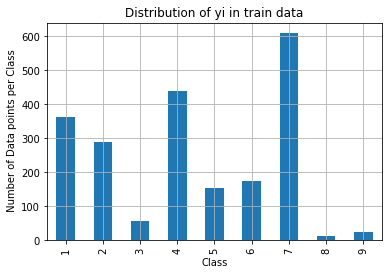

In [58]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [59]:
train_class_distribution.values

array([363, 289,  57, 439, 155, 176, 609,  12,  24], dtype=int64)

In [60]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


Let's visualize the same for test set

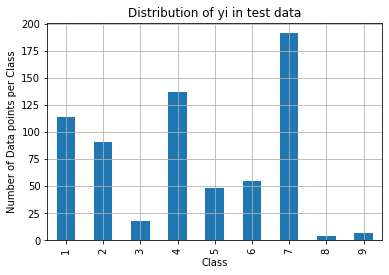

In [61]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [62]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


Let's visualize for cross validation set

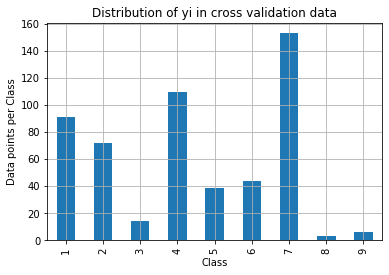

In [63]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [64]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this.

## Building a Random model

Ok, so we need to generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [65]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [66]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)    
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.472143655721914


In [67]:
# Test-Set error.
# we create an output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.5033082987814637


So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [68]:
# Lets get the index of max probablity
predicted_y = np.argmax(test_predicted_y, axis=1)

# Lets see the output. these will be 665 values present in test dataset
predicted_y = predicted_y + 1
predicted_y

array([4, 8, 7, 8, 1, 9, 6, 5, 7, 4, 6, 5, 8, 8, 4, 9, 2, 7, 7, 9, 8, 3,
       9, 5, 7, 6, 3, 3, 4, 5, 7, 5, 1, 6, 7, 6, 5, 1, 5, 5, 5, 5, 8, 7,
       9, 6, 9, 6, 2, 8, 3, 2, 3, 8, 7, 1, 9, 5, 7, 3, 4, 5, 6, 9, 5, 8,
       5, 8, 3, 5, 1, 3, 6, 6, 1, 5, 4, 8, 9, 1, 8, 1, 9, 4, 7, 7, 2, 1,
       8, 3, 5, 9, 3, 9, 4, 3, 8, 3, 5, 9, 2, 5, 7, 3, 6, 4, 6, 8, 9, 2,
       5, 4, 3, 3, 8, 2, 4, 6, 4, 3, 6, 8, 3, 9, 9, 8, 1, 7, 5, 1, 4, 6,
       5, 5, 4, 7, 7, 8, 1, 3, 2, 5, 4, 2, 8, 6, 5, 8, 8, 5, 7, 3, 2, 4,
       1, 3, 9, 3, 4, 7, 4, 5, 9, 9, 2, 7, 9, 1, 7, 4, 5, 2, 1, 7, 6, 6,
       9, 5, 4, 4, 9, 7, 1, 9, 1, 1, 5, 8, 9, 6, 6, 7, 9, 9, 9, 1, 2, 5,
       2, 6, 3, 3, 1, 4, 4, 6, 4, 4, 3, 6, 7, 7, 9, 6, 4, 7, 8, 3, 3, 9,
       4, 7, 8, 2, 7, 3, 4, 2, 3, 8, 1, 6, 4, 6, 6, 1, 4, 8, 9, 6, 6, 5,
       1, 1, 1, 2, 4, 1, 1, 8, 6, 5, 5, 4, 3, 4, 4, 6, 9, 2, 8, 7, 8, 7,
       2, 7, 1, 4, 6, 8, 8, 8, 4, 1, 2, 7, 8, 5, 5, 3, 7, 1, 2, 1, 3, 5,
       8, 9, 3, 6, 2, 6, 3, 4, 7, 2, 6, 5, 9, 9, 2,

### Confusion Matrix

In [69]:
C = confusion_matrix(y_test, predicted_y)

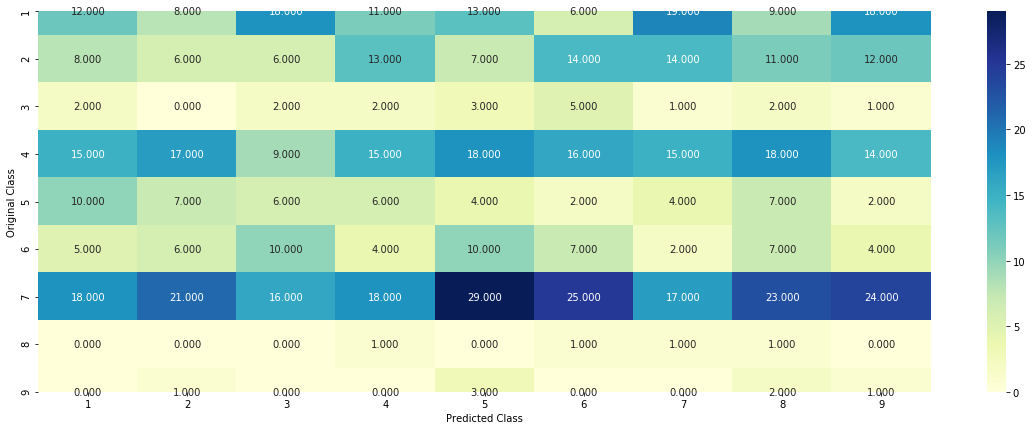

In [70]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Precision matrix

In [71]:
B = (C/C.sum(axis=0))

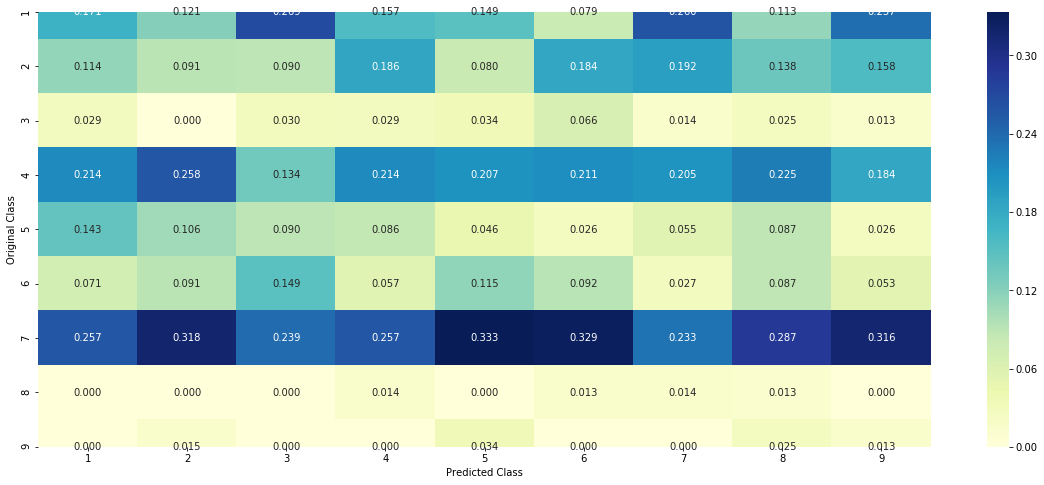

In [72]:
plt.figure(figsize=(20,8))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### Recall matrix

In [73]:
A = (((C.T)/(C.sum(axis=1))).T)

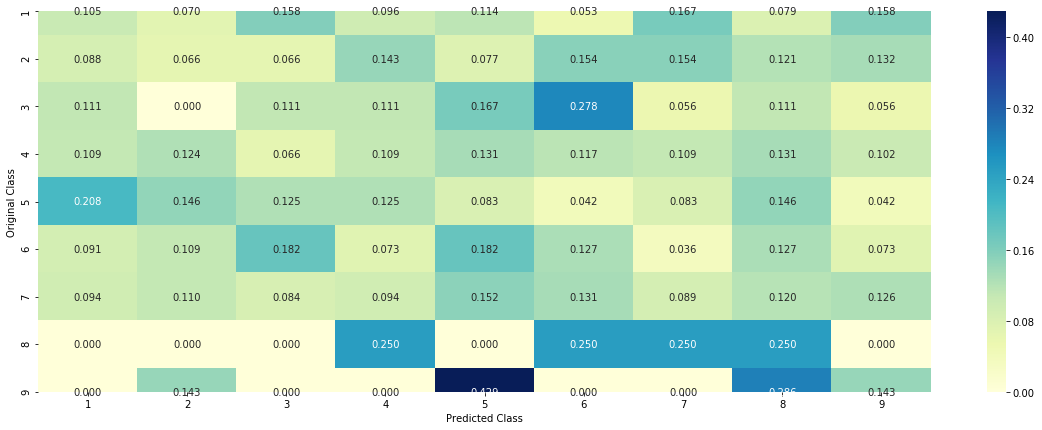

In [74]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Evaluating Gene Column

Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column ***Gene*** and lets look at its distribution. 

In [76]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# the top 10 genes that occured most
print(unique_genes.head(5))

Number of Unique Genes : 230
BRCA1    182
TP53     106
EGFR      84
PTEN      83
BRCA2     80
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

Lets look at the comulative distribution of unique Genes values

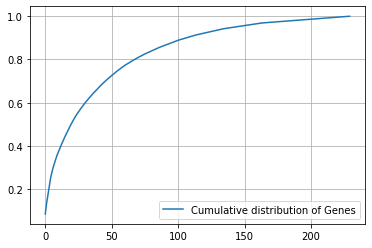

In [77]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it. 

**One-hot encoding**

**Response Encoding**(Mean imputation)

Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [78]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Let's check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [155]:
train_gene_feature_onehotCoding.shape

(2124, 234)

In [79]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'gata3',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hra

Now, lets also create Response encoding columns for Gene column

## Response Encoding:

In [93]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing for learning rate
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of times it occurred 
# in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to particular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

In [103]:
# value_count = dict(train_df['Gene'].value_counts()).keys()
# list(value_count) 

In [94]:
# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
      #     gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [107]:
np.array(get_gv_feature(1, "Gene", train_df))

array([[0.08333333, 0.14166667, 0.08333333, ..., 0.2       , 0.08333333,
        0.08333333],
       [0.08196721, 0.14754098, 0.08196721, ..., 0.2295082 , 0.08196721,
        0.08196721],
       [0.12903226, 0.10752688, 0.10752688, ..., 0.10752688, 0.10752688,
        0.10752688],
       ...,
       [0.08928571, 0.27678571, 0.08928571, ..., 0.09821429, 0.08928571,
        0.08928571],
       [0.19852941, 0.03676471, 0.07352941, ..., 0.03676471, 0.03676471,
        0.03676471],
       [0.07518797, 0.11278195, 0.12030075, ..., 0.29323308, 0.07518797,
        0.07518797]])

In [108]:
# response-coding of the Gene feature
# alpha is used for laplace smoothing for learning rate

alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding.

In [109]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict my 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

In [111]:
# We need a hyperparemeter for SGD (Stochastic Gradient Descent) classifier.
alpha = [10 ** x for x in range(-5, 1)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

## Logistic Regression:

In [116]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
# CalibratedClassifier is used for Probability Distribution

cv_log_error_array = []
for i in alpha:
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    #print(clf.classes_)
    
print(cv_log_error_array)

For values of alpha =  1e-05 The log loss is: 1.246965793070096
For values of alpha =  0.0001 The log loss is: 1.2211202279212139
For values of alpha =  0.001 The log loss is: 1.2443002420407203
For values of alpha =  0.01 The log loss is: 1.335992824234789
For values of alpha =  0.1 The log loss is: 1.4293541539329464
For values of alpha =  1 The log loss is: 1.4733622947288256
[1.246965793070096, 1.2211202279212139, 1.2443002420407203, 1.335992824234789, 1.4293541539329464, 1.4733622947288256]


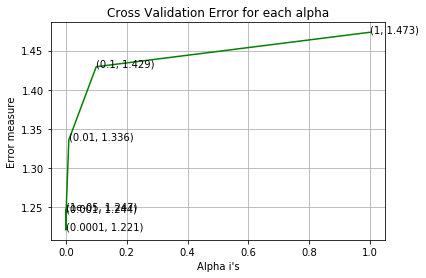

In [120]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [125]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.970300359711175
For values of best alpha =  0.0001 The cross validation log loss is: 1.2211202279212139
For values of best alpha =  0.0001 The test log loss is: 1.1999705725189727


**Now lets check how many values are overlapping between train, test or between CV and train**

In [138]:
test_df[test_df['Gene'].isin( list(set(train_df['Gene'])))].shape[0]

645

**Get All Gene which exists in Train DataSets**:

In [140]:
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage   = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [142]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 512 out of  532 : 96.2406015037594


## Evaluating Variation column

Variation is also a categorical variable so we have to deal in same way like we have done for ***Gene*** column. We will again get the one hot encoder and response enoding variable for variation column.

In [143]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1925
Truncating_Mutations    63
Deletion                46
Amplification           45
Fusions                 21
E17K                     3
T58I                     3
Q61H                     3
Overexpression           3
M1R                      2
R170W                    2
Name: Variation, dtype: int64


Lets look at the comulative distribution of unique ***variation*** values

[0.02966102 0.05131827 0.07250471 ... 0.99905838 0.99952919 1.        ]


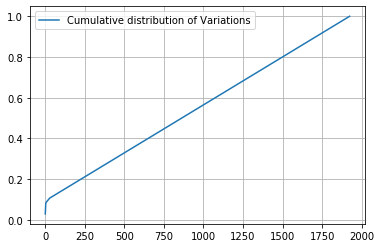

In [144]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Lets convert the variation column using one hot encoder column

In [145]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [146]:
train_variation_feature_onehotCoding.shape

(2124, 1961)

Lets do the same for variation column and generate response encoding for the same.

In [147]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Lets look at the shape of this response encoding result

In [148]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of ***variation*** column

In [149]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

## Apply Logistic Regression:

In [150]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
# loss = log means Logistic Regression

cv_log_error_array=[]
for i in alpha:
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7110830153804546
For values of alpha =  0.0001 The log loss is: 1.7049221371400214
For values of alpha =  0.001 The log loss is: 1.7043891878451316
For values of alpha =  0.01 The log loss is: 1.7046856419539018
For values of alpha =  0.1 The log loss is: 1.7151936426788237
For values of alpha =  1 The log loss is: 1.7187411723882957


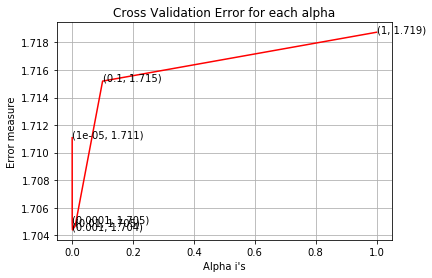

In [152]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='r')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [153]:
best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.0891343442733075
For values of best alpha =  0.001 The cross validation log loss is: 1.7043891878451316
For values of best alpha =  0.001 The test log loss is: 1.7053913857213516


In [154]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [155]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 55 out of  532 : 10.338345864661653


## Evaluating Text column

In [159]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [163]:
import math

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log( ((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)) )
                
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
            
    return text_feature_responseCoding

In [183]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data

text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = {k: v for k, v in zip(list(train_text_features),train_text_fea_counts)}

print("Total number of unique words in train data :", len(train_text_features))
print( sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))

Total number of unique words in train data : 54053
[('mutations', 150122), ('cells', 117793), ('cell', 80614), ('fig', 66931), ('mutation', 66430), ('et', 66121), ('al', 66088), ('cancer', 64274), ('figure', 63039), ('protein', 55062), ('patients', 54130), ('expression', 49835), ('activity', 49635), ('mutant', 47094), ('type', 47024), ('tumor', 43067), ('variants', 42687), ('also', 42329), ('domain', 42170), ('kinase', 41383), ('brca1', 41147), ('binding', 40637), ('using', 40587), ('gene', 39719), ('data', 38441), ('analysis', 37593), ('wild', 36922), ('dna', 36491), ('10', 35681), ('mutants', 34113), ('tumors', 33329), ('two', 33304), ('table', 32787), ('egfr', 32709), ('activation', 32228), ('may', 31747), ('results', 29539), ('shown', 28050), ('ras', 26599), ('proteins', 26157), ('genes', 25957), ('associated', 25901), ('p53', 25871), ('one', 25769), ('used', 24811), ('human', 24591), ('identified', 24512), ('function', 24076), ('found', 23775), ('study', 23488), ('exon', 23400), (

In [176]:
dict_list = list()
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [177]:
# response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding   = get_text_responsecoding(test_df)
cv_text_feature_responseCoding     = get_text_responsecoding(cv_df)

In [178]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  

train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [179]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [184]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = {k: v for k, v in sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True)}
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [185]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5878, 4: 3640, 5: 2885, 6: 2858, 8: 2151, 7: 2046, 10: 1981, 9: 1430, 12: 1227, 11: 1162, 13: 1095, 14: 978, 15: 876, 16: 797, 20: 656, 21: 622, 18: 591, 17: 564, 22: 498, 24: 477, 19: 445, 25: 404, 28: 374, 27: 372, 30: 366, 23: 358, 26: 327, 43: 312, 52: 293, 31: 290, 36: 282, 32: 275, 29: 268, 33: 267, 35: 246, 34: 238, 40: 235, 42: 224, 39: 224, 48: 210, 37: 194, 41: 191, 44: 184, 45: 180, 38: 170, 50: 167, 54: 153, 49: 153, 58: 151, 51: 149, 56: 146, 46: 143, 57: 140, 47: 139, 59: 136, 60: 124, 61: 123, 53: 118, 66: 116, 65: 116, 55: 115, 64: 113, 70: 108, 73: 104, 63: 104, 68: 103, 78: 98, 72: 98, 69: 92, 71: 91, 62: 88, 80: 87, 75: 86, 81: 84, 77: 84, 84: 80, 76: 79, 67: 79, 95: 76, 79: 74, 90: 71, 96: 70, 86: 70, 74: 70, 82: 68, 88: 66, 92: 65, 109: 60, 91: 60, 94: 59, 85: 59, 104: 58, 99: 58, 89: 58, 128: 56, 117: 56, 108: 55, 93: 55, 101: 54, 119: 53, 83: 53, 121: 52, 105: 51, 98: 51, 97: 51, 120: 50, 87: 50, 137: 49, 112: 49, 115: 48, 106: 48, 100: 48, 135: 47, 1

Lets build the model with only ***text*** column

In [186]:
cv_log_error_array=[]

for i in alpha:
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.830889352333539
For values of alpha =  0.0001 The log loss is: 1.8346743865078958
For values of alpha =  0.001 The log loss is: 1.870652295496465
For values of alpha =  0.01 The log loss is: 1.8630295177712413
For values of alpha =  0.1 The log loss is: 1.8761677254565003
For values of alpha =  1 The log loss is: 1.9044383865463965


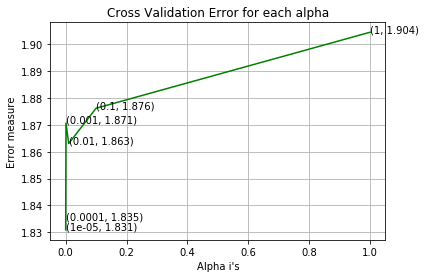

In [187]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [188]:
best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1e-05 The train log loss is: 1.8323600871018442
For values of best alpha =  1e-05 The cross validation log loss is: 1.830889352333539
For values of best alpha =  1e-05 The test log loss is: 1.8312058235435218


Lets check the overlap of text data

In [194]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict =  {k: v for k, v in zip(list(df_text_features),df_text_fea_counts)}
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [195]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

98.194 % of word of test data appeared in train data
98.163 % of word of Cross Validation appeared in train data


So, all 3 columns are going to be important.

## Data prepration for Machine Learning models

Lets create few functions which we will be using later

In [196]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [198]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [201]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 features together

In [200]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [202]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56243)
(number of data points * number of features) in test data =  (665, 56243)
(number of data points * number of features) in cross validation data = (532, 56243)


In [203]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building Machine Learning model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

# Naive Bayes

In [204]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.257485263390637
for alpha = 0.0001
Log Loss : 1.2512493950407546
for alpha = 0.001
Log Loss : 1.2443166333836335
for alpha = 0.1
Log Loss : 1.266290878134526
for alpha = 1
Log Loss : 1.6657535483355446
for alpha = 10
Log Loss : 1.8609715614786706
for alpha = 100
Log Loss : 1.7811733590351693
for alpha = 1000
Log Loss : 1.7017811896869446


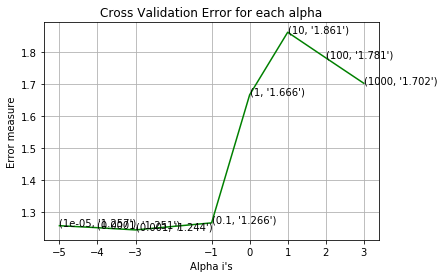

In [205]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [206]:
best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.9464108848436269
For values of best alpha =  0.001 The cross validation log loss is: 1.2443166333836335
For values of best alpha =  0.001 The test log loss is: 1.3518076915303032


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2443166333836335
Number of missclassified point : 0.37593984962406013
-------------------- Confusion matrix --------------------


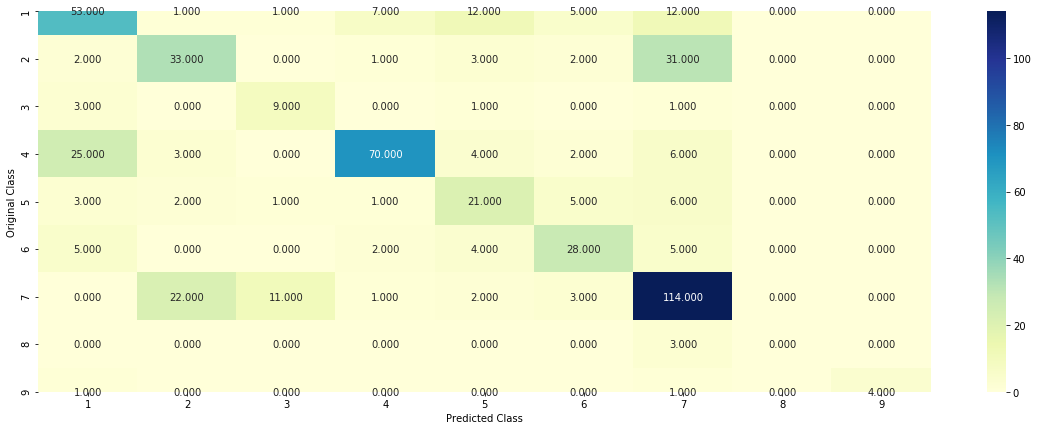

-------------------- Precision matrix (Columm Sum=1) --------------------


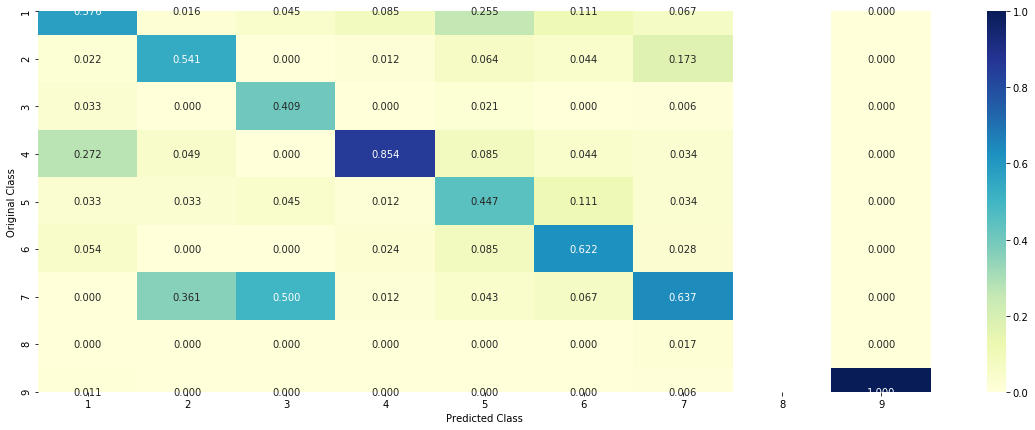

-------------------- Recall matrix (Row sum=1) --------------------


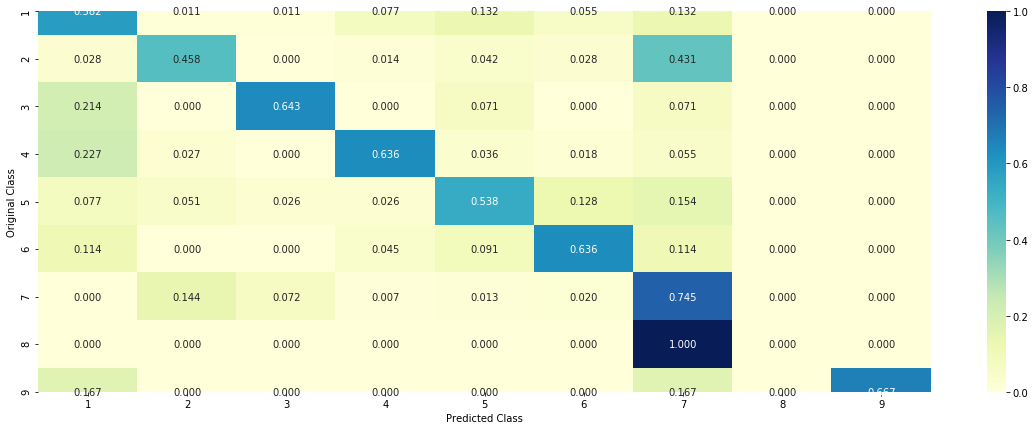

In [207]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of our model

In [208]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.1087 0.098  0.296  0.141  0.1495 0.0474 0.147  0.0077 0.0046]]
Actual Class : 7
--------------------------------------------------
0 Text feature [mutations] present in test data point [True]
2 Text feature [cells] present in test data point [True]
4 Text feature [al] present in test data point [True]
5 Text feature [et] present in test data point [True]
6 Text feature [cancer] present in test data point [True]
8 Text feature [mutation] present in test data point [True]
10 Text feature [activity] present in test data point [True]
12 Text feature [assay] present in test data point [True]
13 Text feature [cell] present in test data point [True]
14 Text feature [protein] present in test data point [True]
15 Text feature [mutants] present in test data point [True]
16 Text feature [functional] present in test data point [True]
17 Text feature [expression] present in test data point [True]
18 Text feature [domain] present in test data po

Lets look at one more point

In [209]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0981 0.0899 0.0157 0.1274 0.3742 0.0431 0.2409 0.0067 0.004 ]]
Actual Class : 6
--------------------------------------------------
2 Text feature [mutations] present in test data point [True]
3 Text feature [cancer] present in test data point [True]
4 Text feature [cells] present in test data point [True]
5 Text feature [protein] present in test data point [True]
6 Text feature [mutation] present in test data point [True]
7 Text feature [functional] present in test data point [True]
8 Text feature [type] present in test data point [True]
9 Text feature [fig] present in test data point [True]
10 Text feature [data] present in test data point [True]
12 Text feature [activity] present in test data point [True]
13 Text feature [assays] present in test data point [True]
14 Text feature [wild] present in test data point [True]
15 Text feature [assay] present in test data point [True]
16 Text feature [binding] present in test data point [

So Naive Bayes not performing very badly but lets look at other models

# K Nearest Neighbour Classification

In [210]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1185648356359639
for alpha = 11
Log Loss : 1.0618968319926947
for alpha = 15
Log Loss : 1.0588485540840469
for alpha = 21
Log Loss : 1.0736696822434064
for alpha = 31
Log Loss : 1.0760268060979985
for alpha = 41
Log Loss : 1.0913878511092963
for alpha = 51
Log Loss : 1.100110635426916
for alpha = 99
Log Loss : 1.1221501773407492


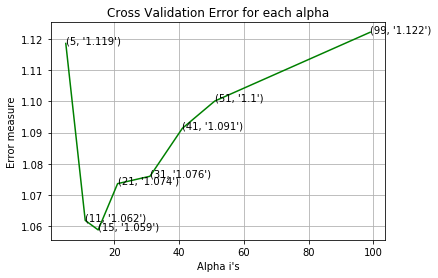

In [211]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [212]:
best_alpha = np.argmin(cv_log_error_array)

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  15 The train log loss is: 0.6497202914933466
For values of best alpha =  15 The cross validation log loss is: 1.0588485540840469
For values of best alpha =  15 The test log loss is: 1.1315411570705705


Let's test it on testing dataset with our best alpha value

Log loss : 1.0588485540840469
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


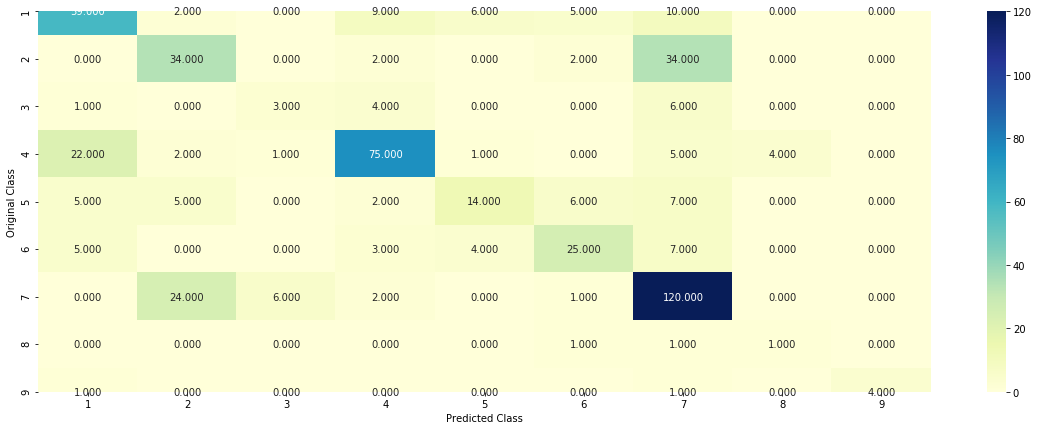

-------------------- Precision matrix (Columm Sum=1) --------------------


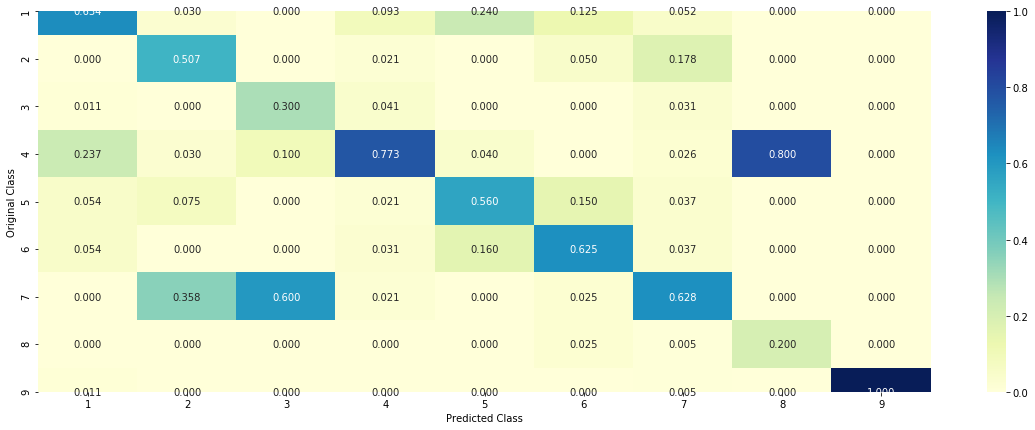

-------------------- Recall matrix (Row sum=1) --------------------


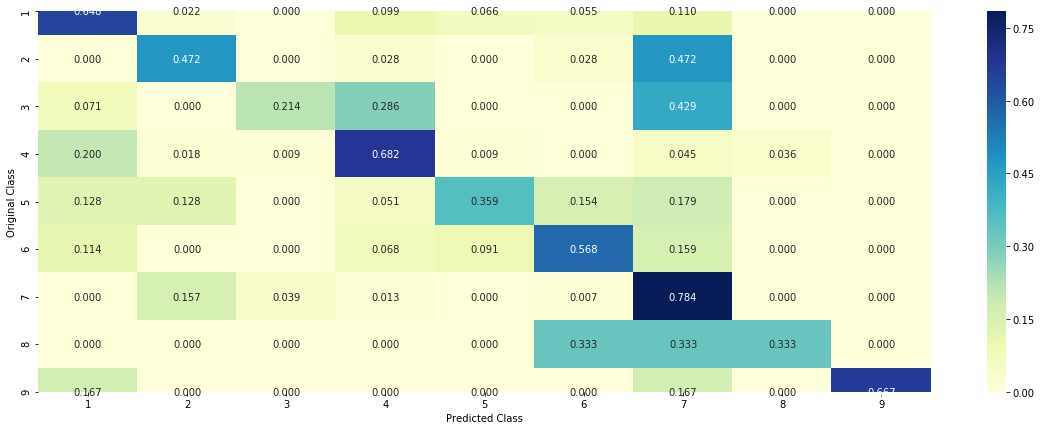

In [213]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [214]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  15  nearest neighbours of the test points belongs to classes [7 3 5 7 7 7 5 7 7 7 7 7 7 2 2]
Fequency of nearest points : Counter({7: 10, 5: 2, 2: 2, 3: 1})


In [215]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 6
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [5 2 2 2 2 2 2 2 7 7 2 2 7 7 7]
Fequency of nearest points : Counter({2: 9, 7: 5, 5: 1})


# Logistic Regression

### Balancing all classes

In [216]:
alpha = [10 ** x for x in range(-6, 3)]

cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.830889352333539
for alpha = 1e-05
Log Loss : 1.830889352333539
for alpha = 0.0001
Log Loss : 1.830889352333539
for alpha = 0.001
Log Loss : 1.8512820839200543
for alpha = 0.01
Log Loss : 1.8617111848413157
for alpha = 0.1
Log Loss : 1.8654672125751839
for alpha = 1
Log Loss : 1.8543946830193483
for alpha = 10
Log Loss : 1.857530682458979
for alpha = 100
Log Loss : 1.8723793220797933


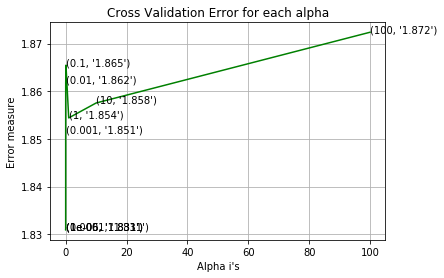

In [217]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [218]:
best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1e-06 The train log loss is: 1.8323600871018442
For values of best alpha =  1e-06 The cross validation log loss is: 1.830889352333539
For values of best alpha =  1e-06 The test log loss is: 1.8312058235435218


Lets test it on testing data using best alpha value

Log loss : 1.830889352333539
Number of mis-classified points : 0.7124060150375939
-------------------- Confusion matrix --------------------


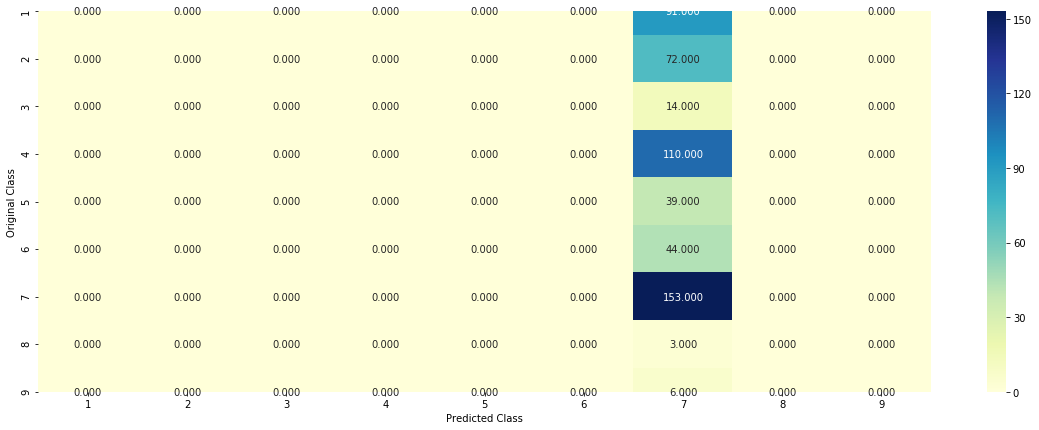

-------------------- Precision matrix (Columm Sum=1) --------------------


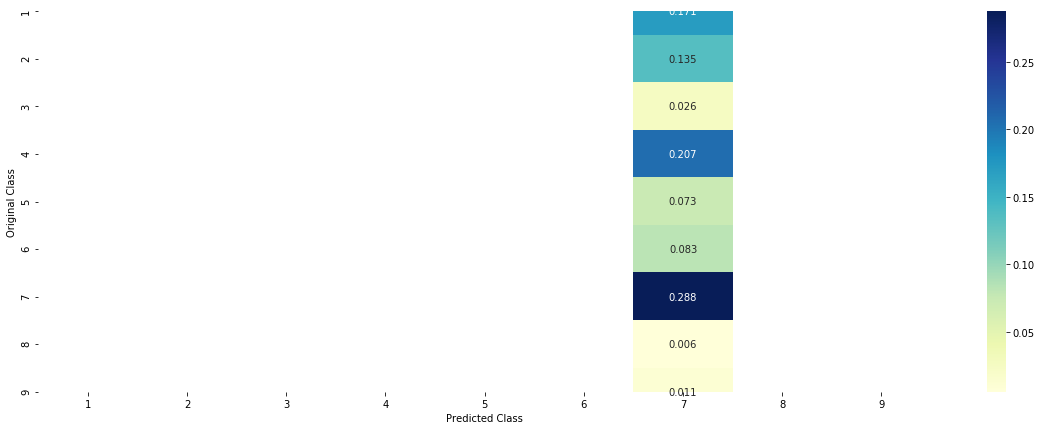

-------------------- Recall matrix (Row sum=1) --------------------


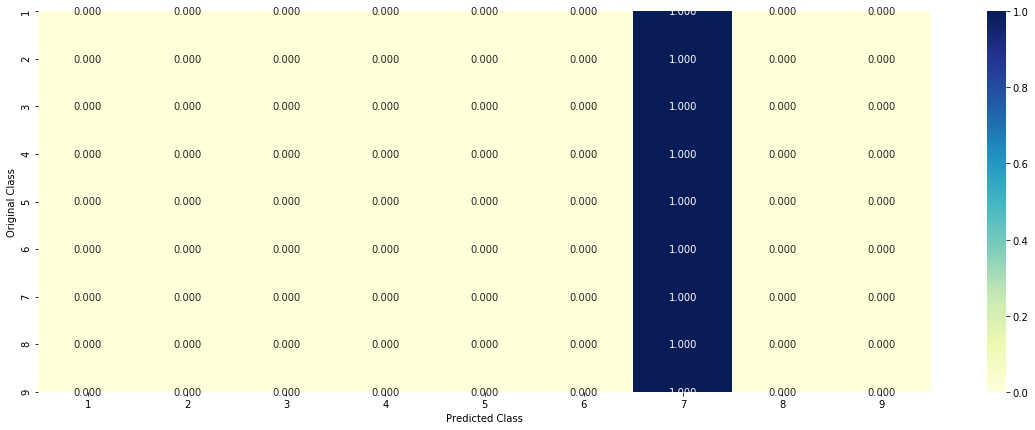

In [220]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [222]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [223]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1697 0.1355 0.0286 0.2047 0.0738 0.0834 0.2831 0.0078 0.0134]]
Actual Class : 7
--------------------------------------------------
2 Text feature [cancers] present in test data point [True]
3 Text feature [mutant] present in test data point [True]
5 Text feature [positive] present in test data point [True]
8 Text feature [11] present in test data point [True]
13 Text feature [activated] present in test data point [True]
15 Text feature [phospho] present in test data point [True]
16 Text feature [activation] present in test data point [True]
17 Text feature [binding] present in test data point [True]
22 Text feature [similar] present in test data point [True]
23 Text feature [found] present in test data point [True]
24 Text feature [22] present in test data point [True]
26 Text feature [fig] present in test data point [True]
33 Text feature [mechanisms] present in test data point [True]
36 Text feature [two] present in test data poi

In [224]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1697 0.1355 0.0286 0.2047 0.0738 0.0834 0.2831 0.0078 0.0134]]
Actual Class : 6
--------------------------------------------------
2 Text feature [cancers] present in test data point [True]
3 Text feature [mutant] present in test data point [True]
5 Text feature [positive] present in test data point [True]
7 Text feature [downstream] present in test data point [True]
8 Text feature [11] present in test data point [True]
13 Text feature [activated] present in test data point [True]
14 Text feature [cyclin] present in test data point [True]
15 Text feature [phospho] present in test data point [True]
16 Text feature [activation] present in test data point [True]
17 Text feature [binding] present in test data point [True]
20 Text feature [amplification] present in test data point [True]
22 Text feature [similar] present in test data point [True]
23 Text feature [found] present in test data point [True]
24 Text feature [22] present in t

448 Text feature [gfp] present in test data point [True]
449 Text feature [interestingly] present in test data point [True]
455 Text feature [might] present in test data point [True]
457 Text feature [american] present in test data point [True]
462 Text feature [could] present in test data point [True]
463 Text feature [57] present in test data point [True]
474 Text feature [nucleotides] present in test data point [True]
475 Text feature [24] present in test data point [True]
485 Text feature [segment] present in test data point [True]
493 Text feature [pcr] present in test data point [True]
494 Text feature [malignant] present in test data point [True]
Out of the top  500  features  145 are present in query point


## Without Class balancing

In [225]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.830889352333539
for alpha = 1e-05
Log Loss : 1.830889352333539
for alpha = 0.0001
Log Loss : 1.8346669656068457
for alpha = 0.001
Log Loss : 1.866212073629411
for alpha = 0.01
Log Loss : 1.8782576528627652
for alpha = 0.1
Log Loss : 1.869901041044483
for alpha = 1
Log Loss : 1.8973438779199874


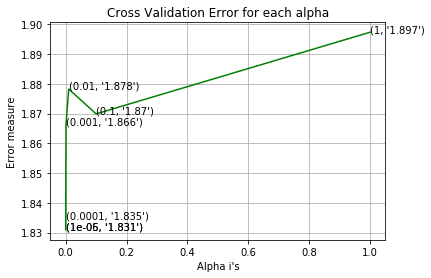

In [226]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [227]:
best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1e-06 The train log loss is: 1.8323600871018442
For values of best alpha =  1e-06 The cross validation log loss is: 1.830889352333539
For values of best alpha =  1e-06 The test log loss is: 1.8312058235435218


Lets test our model with best hyper param

Log loss : 1.830889352333539
Number of mis-classified points : 0.7124060150375939
-------------------- Confusion matrix --------------------


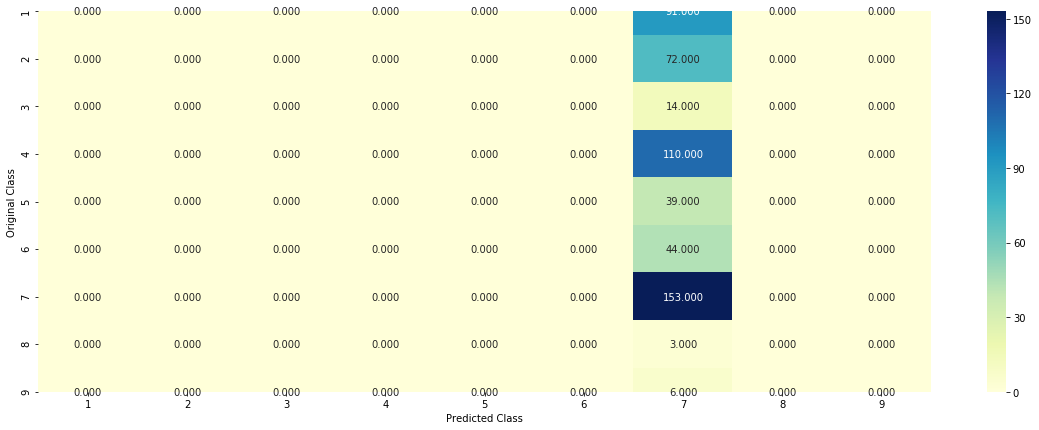

-------------------- Precision matrix (Columm Sum=1) --------------------


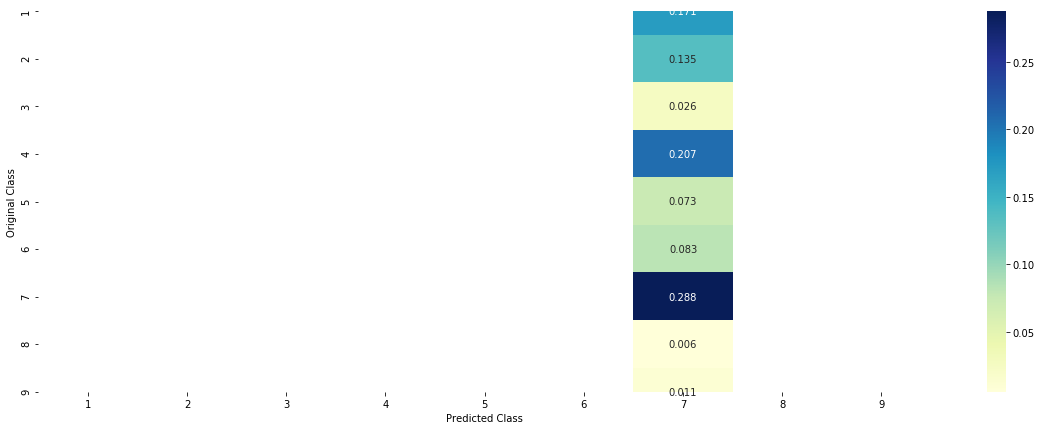

-------------------- Recall matrix (Row sum=1) --------------------


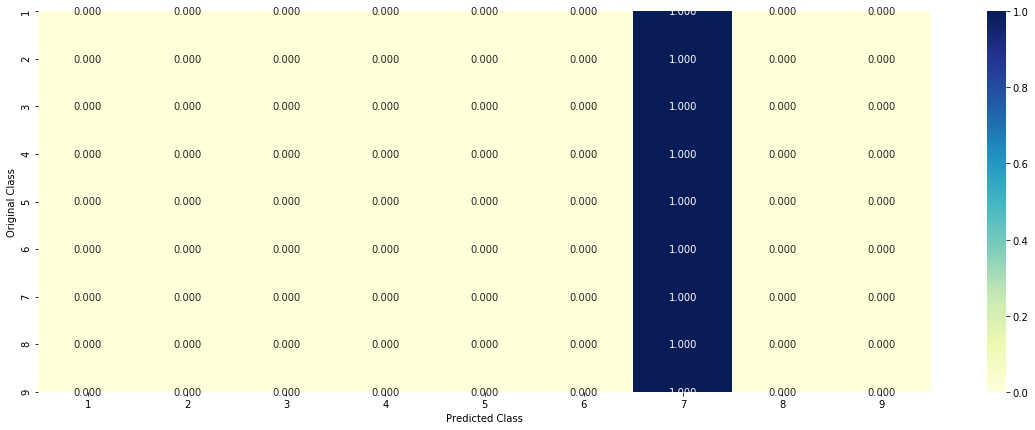

In [228]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Testing query point and interpretability

In [232]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 10

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1697 0.1355 0.0286 0.2047 0.0738 0.0834 0.2831 0.0078 0.0134]]
Actual Class : 7
--------------------------------------------------
2 Text feature [positive] present in test data point [True]
4 Text feature [cancers] present in test data point [True]
5 Text feature [11] present in test data point [True]
Out of the top  10  features  3 are present in query point


# Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.830889352333539
for C = 0.0001
Log Loss : 1.8309852165201324
for C = 0.001
Log Loss : 1.8615797160309442
for C = 0.01
Log Loss : 1.855133236354047
for C = 0.1
Log Loss : 1.8559920310559666
for C = 1
Log Loss : 1.8525362470848459
for C = 10
Log Loss : 1.846841433823279
for C = 100
Log Loss : 1.8611213185483786


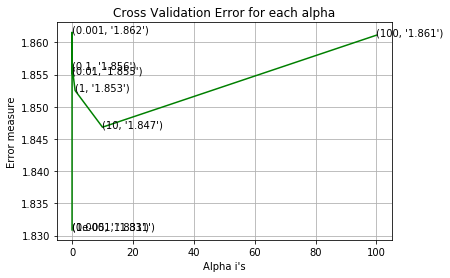

For values of best alpha =  1e-05 The train log loss is: 1.8323600871018442
For values of best alpha =  1e-05 The cross validation log loss is: 1.830889352333539
For values of best alpha =  1e-05 The test log loss is: 1.8312058235435218


In [233]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    
#   clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing model with best alpha values

Log loss : 1.830889352333539
Number of mis-classified points : 0.7124060150375939
-------------------- Confusion matrix --------------------


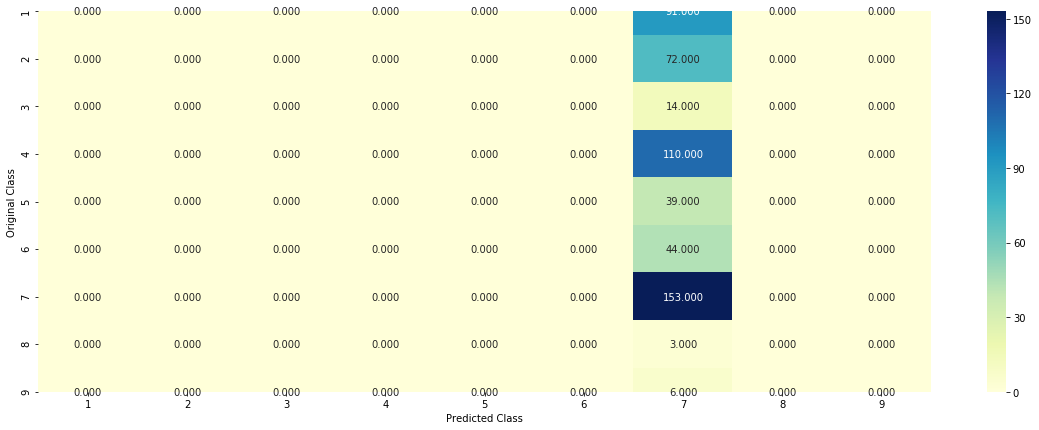

-------------------- Precision matrix (Columm Sum=1) --------------------


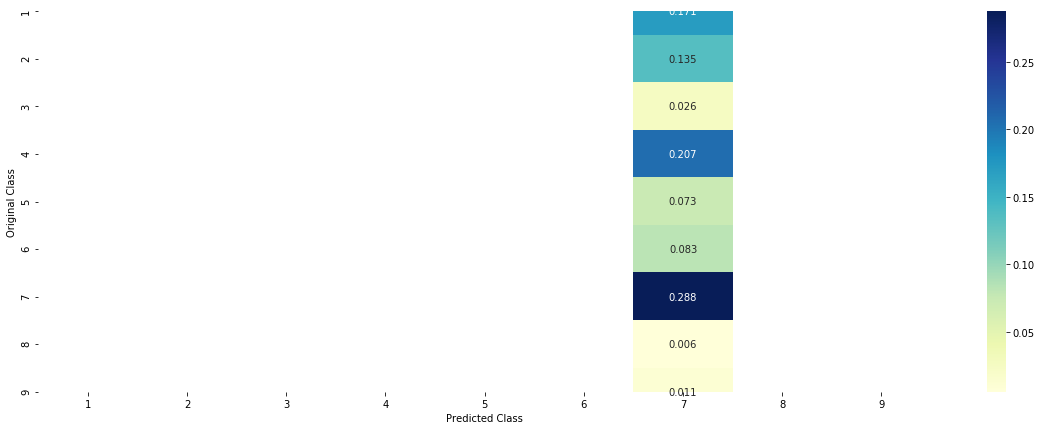

-------------------- Recall matrix (Row sum=1) --------------------


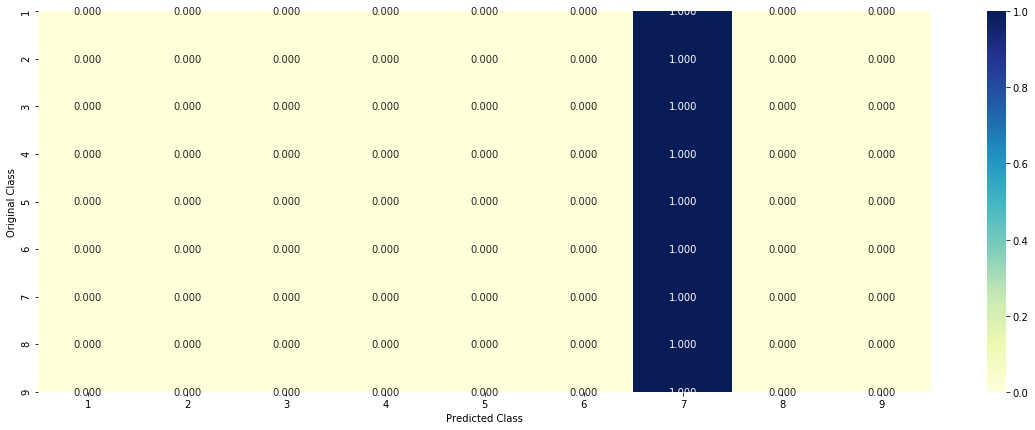

In [234]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [236]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
# test_point_index = 100
# no_feature = 500
no_feature = 10
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1697 0.1355 0.0286 0.2047 0.0738 0.0834 0.2831 0.0078 0.0134]]
Actual Class : 7
--------------------------------------------------
2 Text feature [cancers] present in test data point [True]
6 Text feature [11] present in test data point [True]
Out of the top  10  features  2 are present in query point


# Random Forest Classifier

## Model with One hot encoder

In [237]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 2.0041508624277924
for n_estimators = 100 and max depth =  10
Log Loss : 2.0170513589262025
for n_estimators = 200 and max depth =  5
Log Loss : 2.0289156923287783
for n_estimators = 200 and max depth =  10
Log Loss : 2.039062792970185
for n_estimators = 500 and max depth =  5
Log Loss : 2.037257573910235
for n_estimators = 500 and max depth =  10
Log Loss : 2.0563728317549925
for n_estimators = 1000 and max depth =  5
Log Loss : 2.0449835955184796
for n_estimators = 1000 and max depth =  10
Log Loss : 2.065724371721676
for n_estimators = 2000 and max depth =  5
Log Loss : 2.048899355705771
for n_estimators = 2000 and max depth =  10
Log Loss : 2.067090004435393


In [238]:
best_alpha = np.argmin(cv_log_error_array)

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  100 The train log loss is: 1.0029819172987173
For values of best estimator =  100 The cross validation log loss is: 2.004150862427793
For values of best estimator =  100 The test log loss is: 2.0082006108367394


Lets test it on testing data using best hyper param

Log loss : 2.0041508624277924
Number of mis-classified points : 0.793233082706767
-------------------- Confusion matrix --------------------


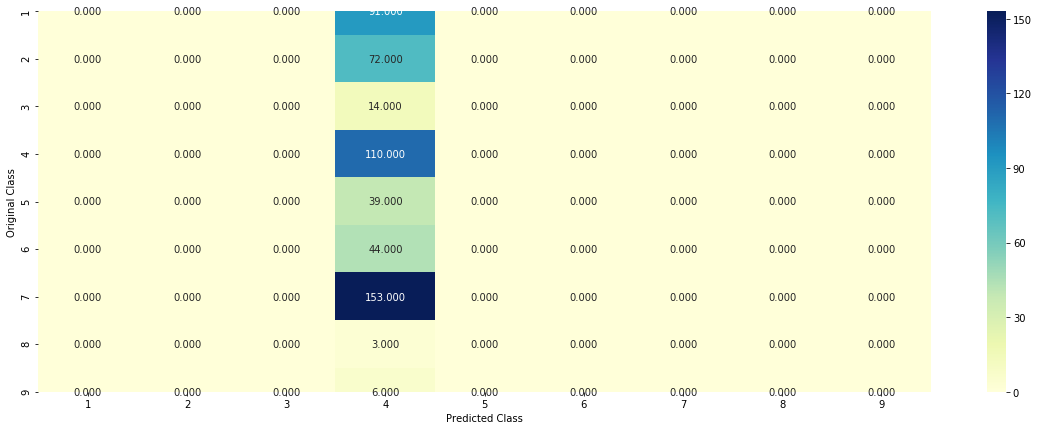

-------------------- Precision matrix (Columm Sum=1) --------------------


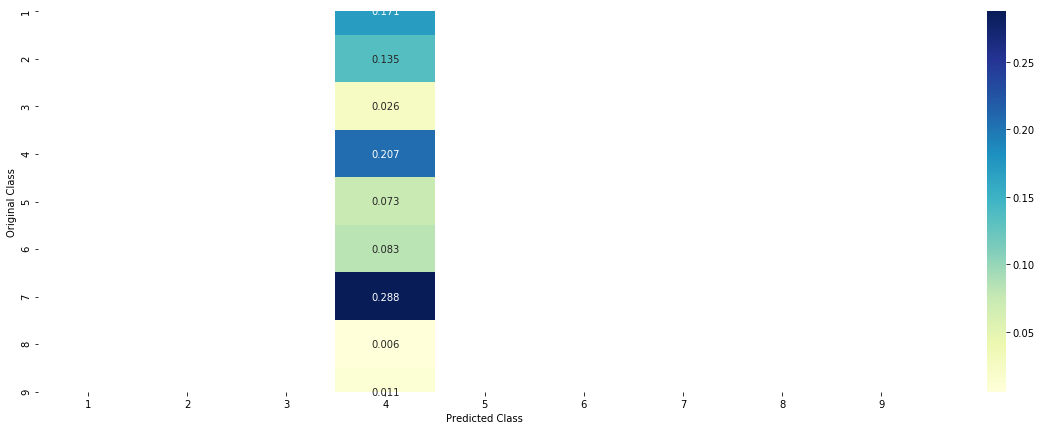

-------------------- Recall matrix (Row sum=1) --------------------


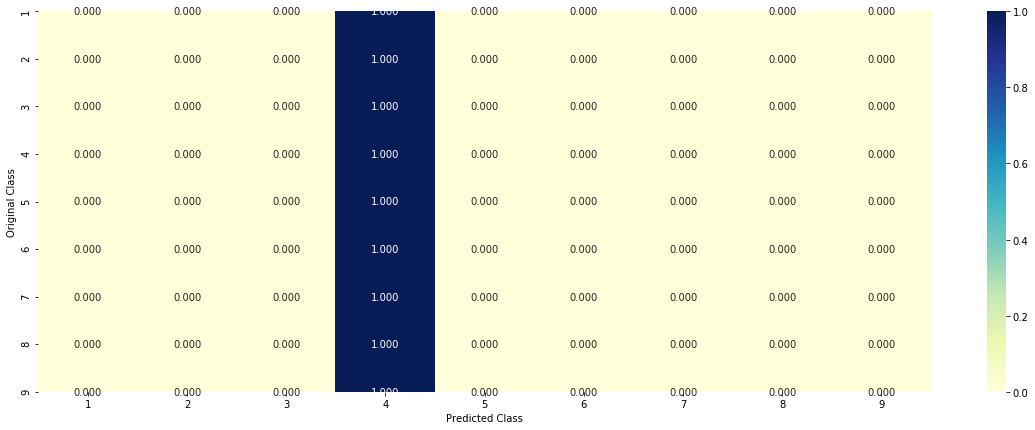

In [239]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [240]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2654 0.0971 0.0243 0.3567 0.0722 0.0755 0.0928 0.0072 0.0088]]
Actual Class : 7
--------------------------------------------------
1 Text feature [erk] present in test data point [True]
10 Text feature [phospho] present in test data point [True]
11 Text feature [activated] present in test data point [True]
12 Text feature [cell] present in test data point [True]
13 Text feature [inhibitor] present in test data point [True]
17 Text feature [functional] present in test data point [True]
18 Text feature [activate] present in test data point [True]
20 Text feature [kinase] present in test data point [True]
22 Text feature [cells] present in test data point [True]
23 Text feature [receptor] present in test data point [True]
25 Text feature [growth] present in test data point [True]
33 Text feature [loss] present in test data point [True]
42 Text feature [inhibition] present in test data point [True]
49 Text feature [oncogenic] present i

## Random Forest with Response Coding:

In [241]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0666757892149743
for n_estimators = 10 and max depth =  3
Log Loss : 1.5552042203754155
for n_estimators = 10 and max depth =  5
Log Loss : 1.5066632964984823
for n_estimators = 10 and max depth =  10
Log Loss : 1.6494796027739538
for n_estimators = 50 and max depth =  2
Log Loss : 1.7377383100951378
for n_estimators = 50 and max depth =  3
Log Loss : 1.4580107920362098
for n_estimators = 50 and max depth =  5
Log Loss : 1.336858527167223
for n_estimators = 50 and max depth =  10
Log Loss : 1.544152797142561
for n_estimators = 100 and max depth =  2
Log Loss : 1.6150752281246699
for n_estimators = 100 and max depth =  3
Log Loss : 1.4728400929172012
for n_estimators = 100 and max depth =  5
Log Loss : 1.3169539075098446
for n_estimators = 100 and max depth =  10
Log Loss : 1.5377419961453616
for n_estimators = 200 and max depth =  2
Log Loss : 1.6327242913393352
for n_estimators = 200 and max depth =  3
Log Loss : 1.4716980484437234

Testing model with best hyper param

Log loss : 1.3169539075098446
Number of mis-classified points : 0.4605263157894737
-------------------- Confusion matrix --------------------


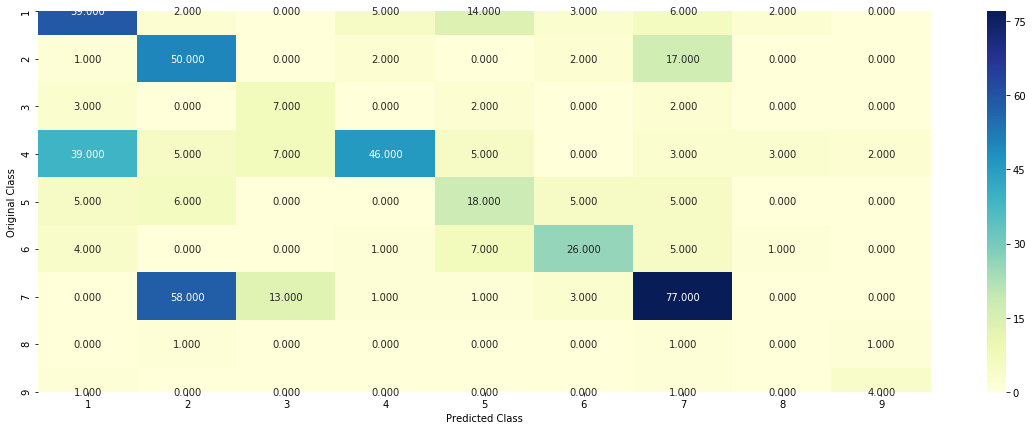

-------------------- Precision matrix (Columm Sum=1) --------------------


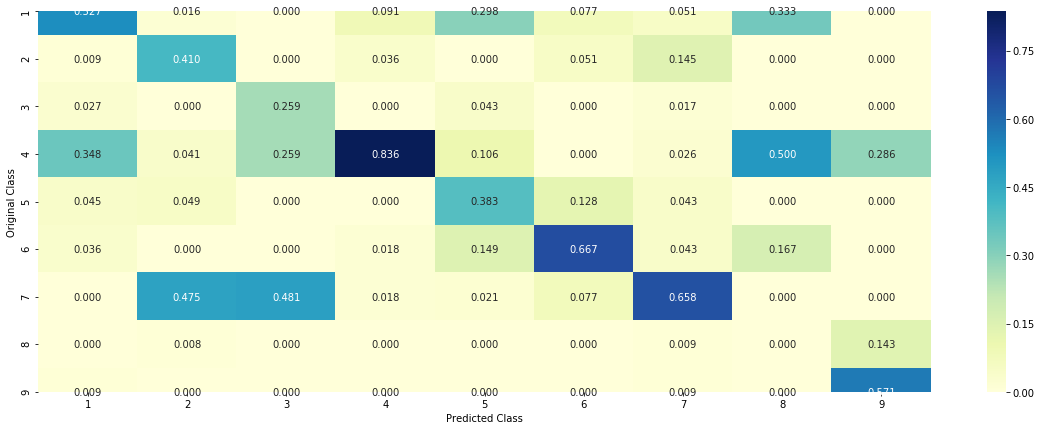

-------------------- Recall matrix (Row sum=1) --------------------


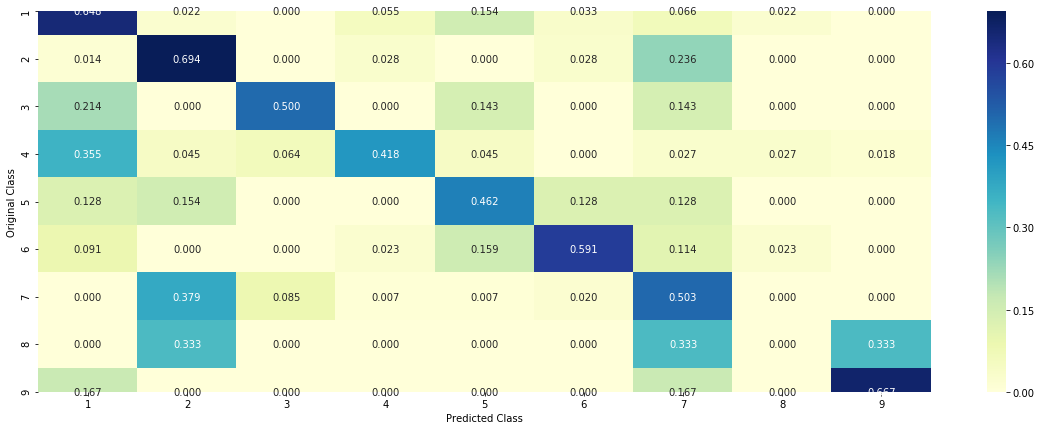

In [242]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [243]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.024  0.2561 0.1651 0.0273 0.0727 0.0434 0.3489 0.0384 0.0241]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


# Stacking model

In [244]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.85
Support vector machines : Log Loss: 1.86
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.827
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.801
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.661
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.440
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.368
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.457


Testing with best hyper param

Log loss (train) on the stacking classifier : 0.6967561610872227
Log loss (CV) on the stacking classifier : 1.4403825429514443
Log loss (test) on the stacking classifier : 1.4998538543896551
Number of missclassified point : 0.44661654135338347
-------------------- Confusion matrix --------------------


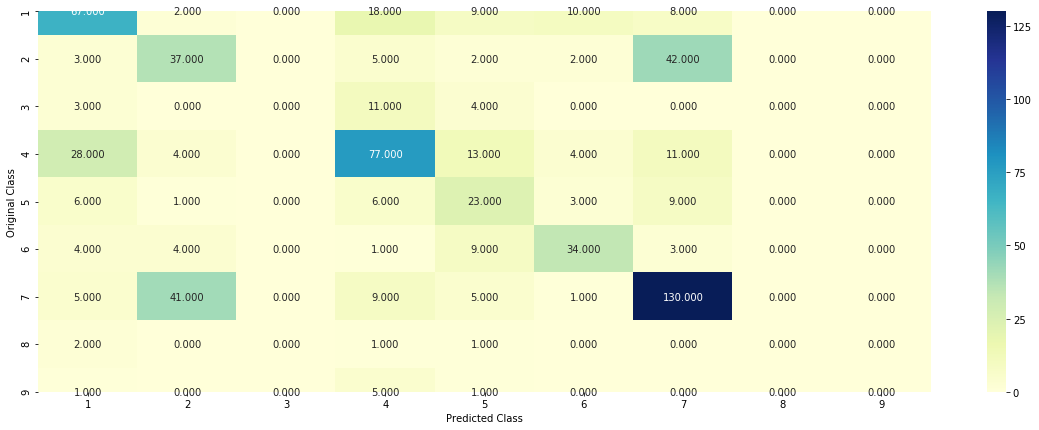

-------------------- Precision matrix (Columm Sum=1) --------------------


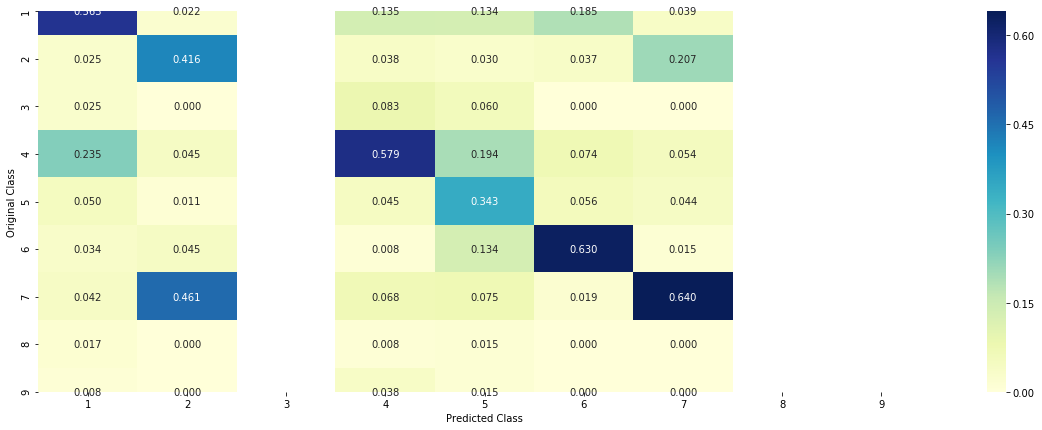

-------------------- Recall matrix (Row sum=1) --------------------


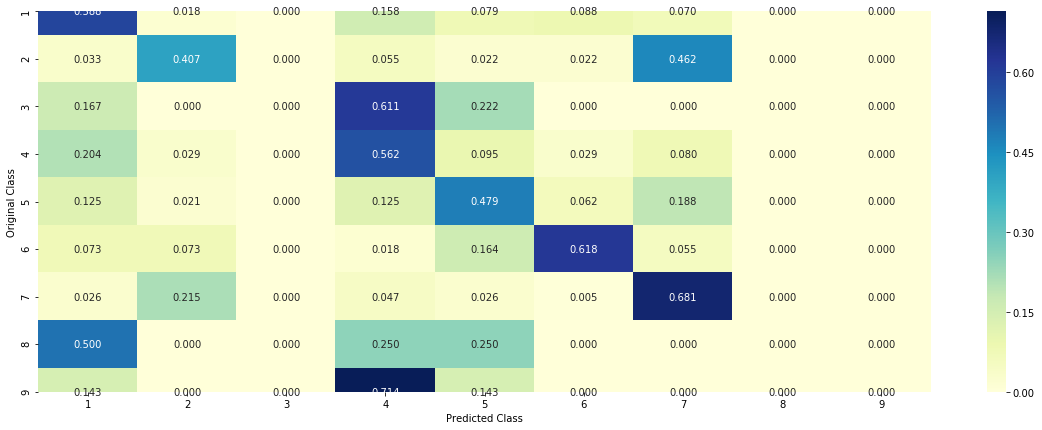

In [245]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

# Maximum voting Classifier

Log loss (train) on the VotingClassifier : 0.8750427651371779
Log loss (CV) on the VotingClassifier : 1.512024205507654
Log loss (test) on the VotingClassifier : 1.5611355247659093
Number of missclassified point : 0.43007518796992483
-------------------- Confusion matrix --------------------


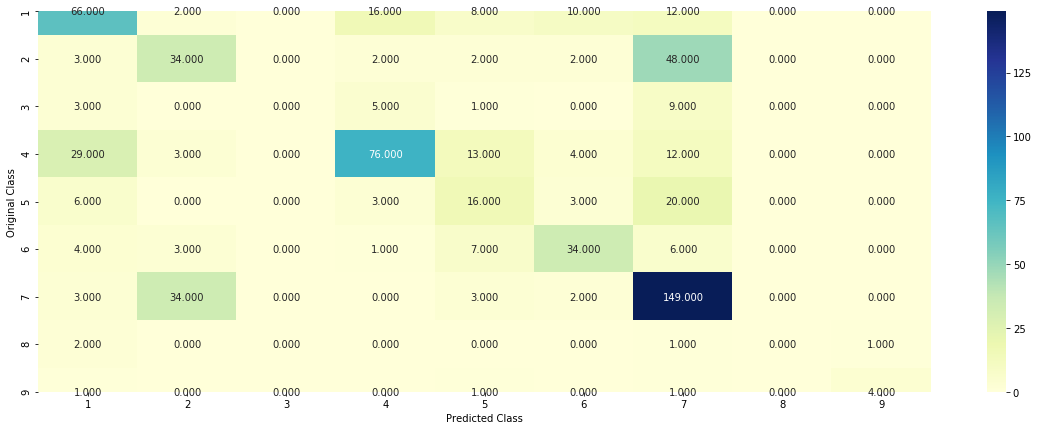

-------------------- Precision matrix (Columm Sum=1) --------------------


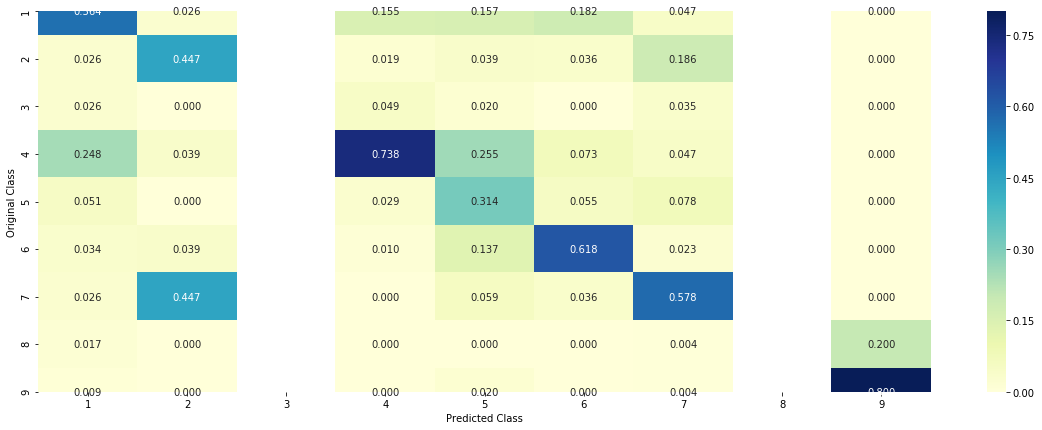

-------------------- Recall matrix (Row sum=1) --------------------


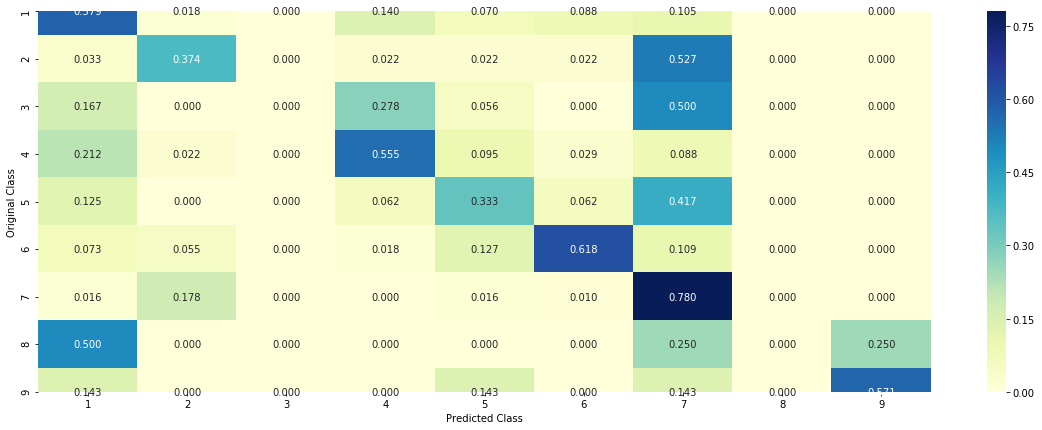

In [246]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))